In [1]:
# Execute if necessary
# %%capture
# !pip install pandas
!pip install statsmodels
!pip install pmdarima


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import plotly.express as px
from statsmodels.graphics.api import qqplot
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_predict
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# Práctica 7: Modelos Integrados (ARIMA y SARIMA)

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones.

La entrega de la práctica será en la siguiente sesión a menos que la indicación sea otra. La revisión iniciará al iniciar la sesión y únicamente podrá ser evaluada durante la duración de la sesión.

__Para esta práctica se deben usar bibliotecas__. Se recomienda el uso de:

- scikit-learn (https://scikit-learn.org/stable/)
- plotly express (https://plotly.com/python/plotly-express/)
- statsmodels (https://www.statsmodels.org/stable/index.html).

## Asignación 1

Seleccione algun dataset de su preferencia que sea relacionado a series de tiempo. Particione sus datos para poder evaluar el desempeño de su práctica (__conjunto de test__).

In [3]:
# cargamos el dataset
data = pd.read_csv('./avocado.csv')

# total = df[df.geography == 'Total U.S.']

df1 = data.copy(deep = True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace = True)
df1 = df1.resample('W').sum()
df1.head()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
Date,,,,,,,,,,,
2015-01-04,5507,140.54,8.467434e+07,33098258.74,36851038.43,2278818.64,12446221.39,9910008.90,2485655.90,50556.59,217620
2015-01-11,5399,148.03,7.855581e+07,31024164.99,32808429.84,2349167.45,12374044.96,10352936.42,1977832.00,43276.54,217620
2015-01-18,5291,150.24,7.838878e+07,31802706.86,31662041.93,2208250.55,12715784.74,10548854.11,2145586.13,21344.50,217620
2015-01-25,5183,150.89,7.646628e+07,32305132.87,28929122.37,2078378.86,13153646.97,10877316.95,2252815.92,23514.10,217620
2015-02-01,5075,134.68,1.194532e+08,50292988.96,50696230.48,3687489.31,14776526.50,11576833.65,3073989.39,125703.46,217620


In [4]:
#Escalar los datos
df1['Log_AveragePrice'] = np.log(df1['AveragePrice'])

/tmp/ipykernel_271/1581498918.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['AveragePrice']);
/tmp/ipykernel_271/1581498918.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['AveragePrice']);
/tmp/ipykernel_271/1581498918.py:14: UserWarning: Ignoring `palette` because no `hue` v

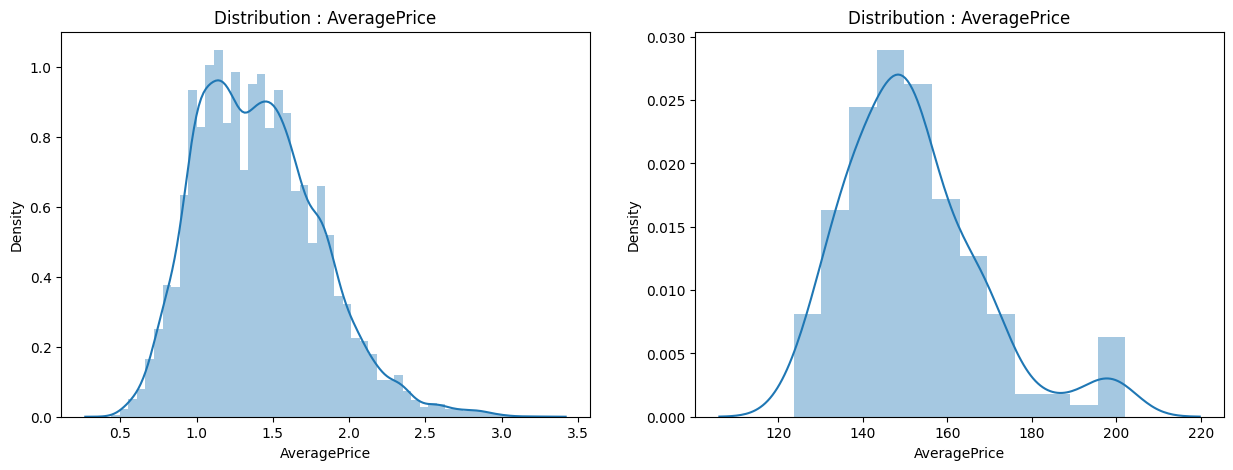

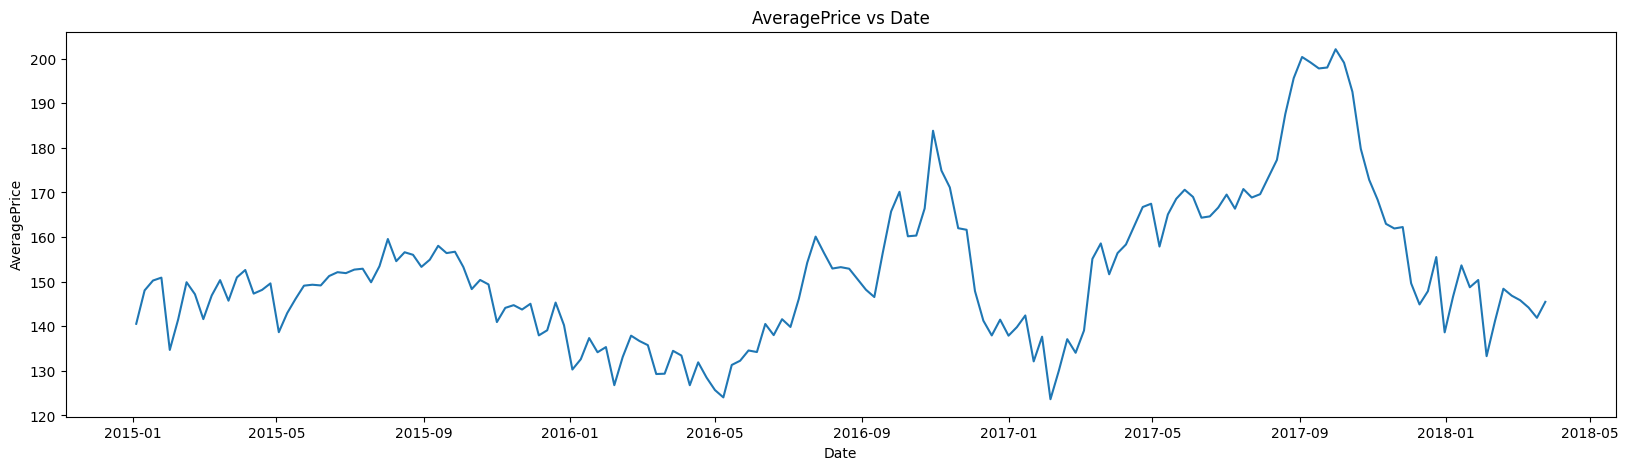

In [5]:
color1 = ['#296C92','#3EB489']
fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,5))

plt.subplot(1,2,1)
sns.distplot(data['AveragePrice']);
plt.title('Distribution : AveragePrice')

plt.subplot(1,2,2)
sns.distplot(df1['AveragePrice']);
plt.title('Distribution : AveragePrice')

fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (20,5))
plt.subplot(1,1,1)
sns.lineplot(x = df1.index ,y = 'AveragePrice',data = df1,palette = color1);
plt.title('AveragePrice vs Date')

plt.show()
fig.tight_layout(pad = 2)

### Dividir los datos en train y test

Train contendrá un 80% de los datos, mientras que Test abarcara el 30% restante.

In [6]:
# separamos los datos
n = int(np.shape(df1.AveragePrice)[0] * 0.8)
X_train, X_test = df1.index[0 : n], df1.index[n-1: ]
y_train, y_test = df1.AveragePrice[0 : n], df1.AveragePrice[n-1:]

## Asignación 2

Realice un análisis exploratorio de datos y el preprocesamiento necesario para el dataset seleccionado. El análisis realizado debe respaldar (preferentemente mediante el uso de gráficas) las decisiones que tome para la siguiente asignación.

In [7]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window = 12).mean()
    MSTD = timeseries.rolling(window = 12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [8]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, zero=False, auto_ylims=True)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, zero=False, auto_ylims=True)
        plt.tight_layout()

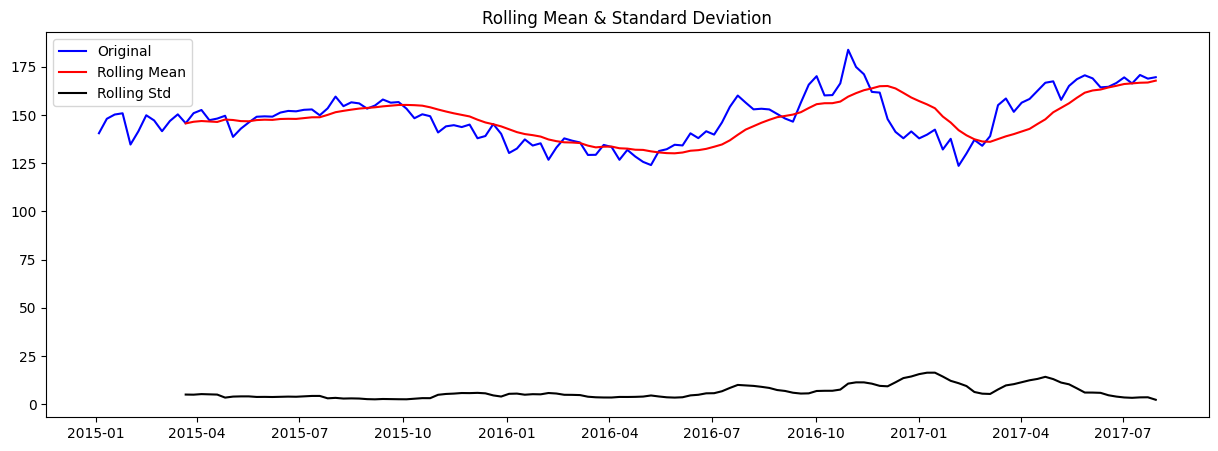

Results of Dickey-Fuller Test:
Test Statistic                  -2.337152
p-value                          0.160266
#Lags Used                       0.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


In [9]:
test_stationarity(y_train)

Para comprobar la estacionareidad de acuerdo con el test de **Dickey-Fuller**, se deben cumplir dos condiciones

- **Test Statistic** < **Critical Value (5%)** 

- **p-value** < 0.05

Para la serie de timepo original, se tiene que:

- Test Statistic (-2.337152) < -2.883362

- p-value (0.160266) < 0.05

por lo que la serie **no es estacionaria**, se aplica un diferencia a los datos y se vuelve a corroborar la estacionariedad de los datos


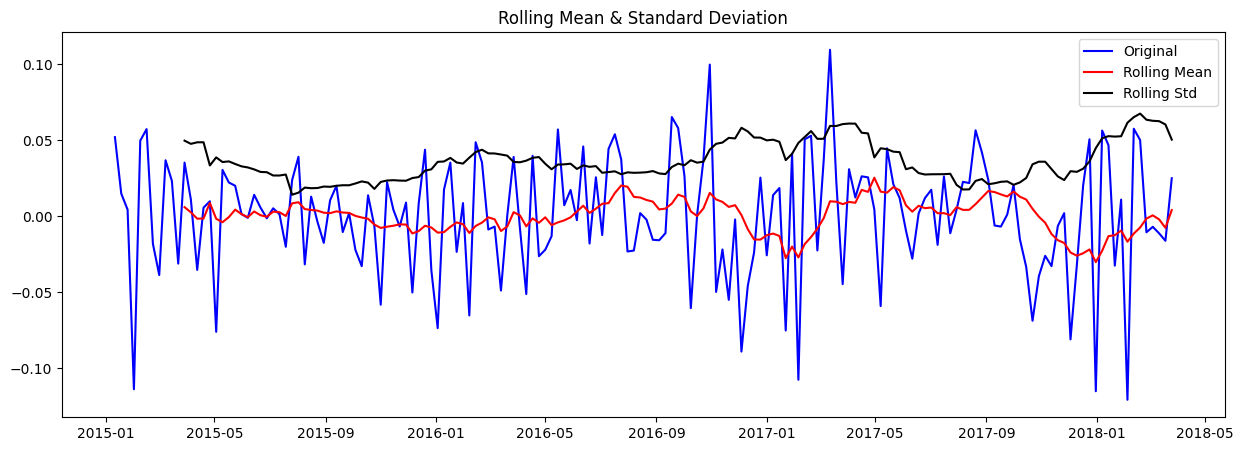

Results of Dickey-Fuller Test:
Test Statistic                -1.381774e+01
p-value                        8.010524e-26
#Lags Used                     0.000000e+00
Number of Observations Used    1.670000e+02
Critical Value (1%)           -3.470126e+00
Critical Value (5%)           -2.879008e+00
Critical Value (10%)          -2.576083e+00
dtype: float64


In [10]:

df1_log_diff = df1['Log_AveragePrice'].diff().dropna()
test_stationarity(df1_log_diff)
# dec = sm.tsa.seasonal_decompose(df1_log_diff,period = 52).plot()
# plt.show()

Despues de la diferenciación ya se cumplen las condiciones del **Dickey-Fuller** Test:

-1.381774e+01 < -2.879008e+00
8.010524e-26 < 0.05


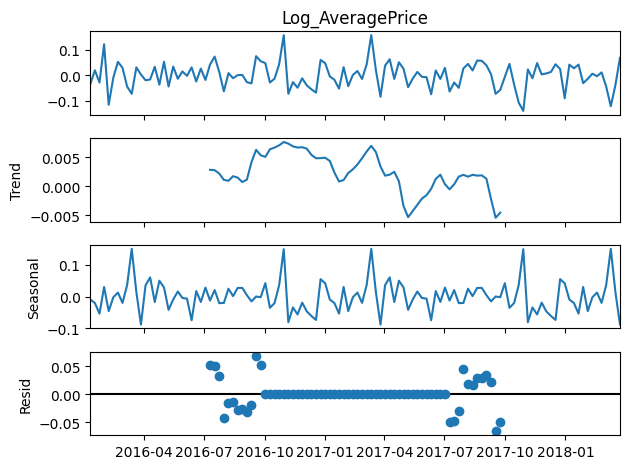

In [11]:
# Primer bloque de codigo de sarima
df1_log_diff_seas = df1_log_diff.diff(52)
df1_log_diff_seas = df1_log_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(df1_log_diff_seas).plot()
plt.show()

- En el caso de nuestros datos, están en formato semanal y el periodo estacional es de 1 año.
- Por lo tanto, diferenciamos los datos por un valor de periodicidad, M, de 52.
- Podemos observar que la estacionalidad de los datos casi ha desaparecido con valores en el eje y que oscilan entre -0,1 y 0,1.
- Comprobaremos la estacionariedad de estos datos diferenciados estacionalmente.

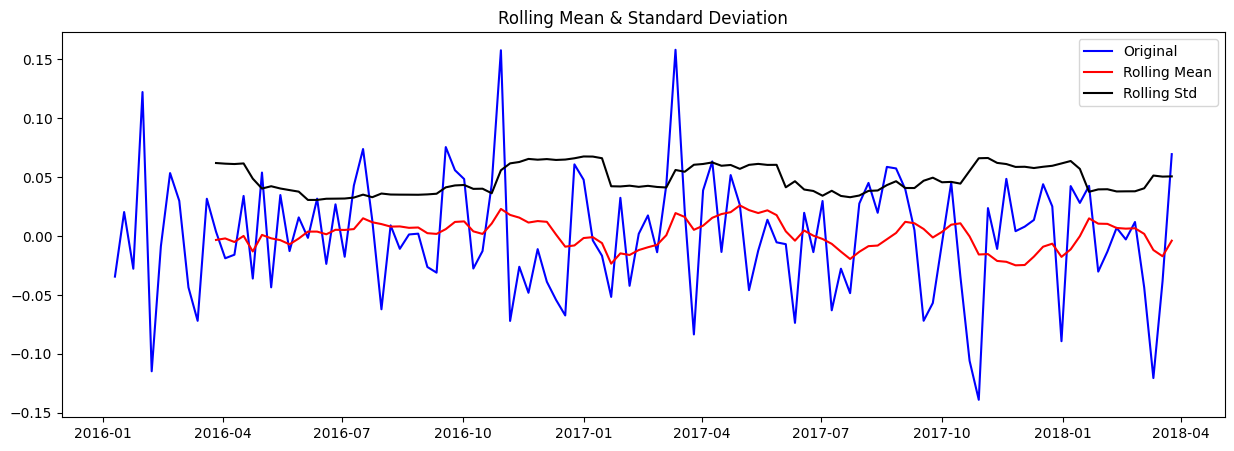

Results of Dickey-Fuller Test:
Test Statistic                  -4.596151
p-value                          0.000131
#Lags Used                      11.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


In [12]:
test_stationarity(df1_log_diff_seas)

- A partir de los resultados de la prueba Dickey Fuller aumentada,
- La media móvil está muy próxima a 0, pero presenta variaciones muy pequeñas.
- La desviación típica móvil está muy próxima a 0,05, con algunas crestas y depresiones.
- Valor crítico (5%): (-2,89) > Estadística de prueba: (-4,60). Podemos afirmar que la serie temporal es estacionaria con un 99% de - confianza, ya que el estadístico de prueba también es inferior al valor crítico (1%).
- 0,05 > valor p (0,00)
- A partir de estos resultados, podemos rechazar la Hipótesis Nula y aceptar la Hipótesis Alterna, es decir, podemos decir que la serie de tiempo anterior es estacionaria.

## Asignación 3

Ajuste un modelo ARMA, ARIMA o SARIMA segun sea conveniente para sus datos.

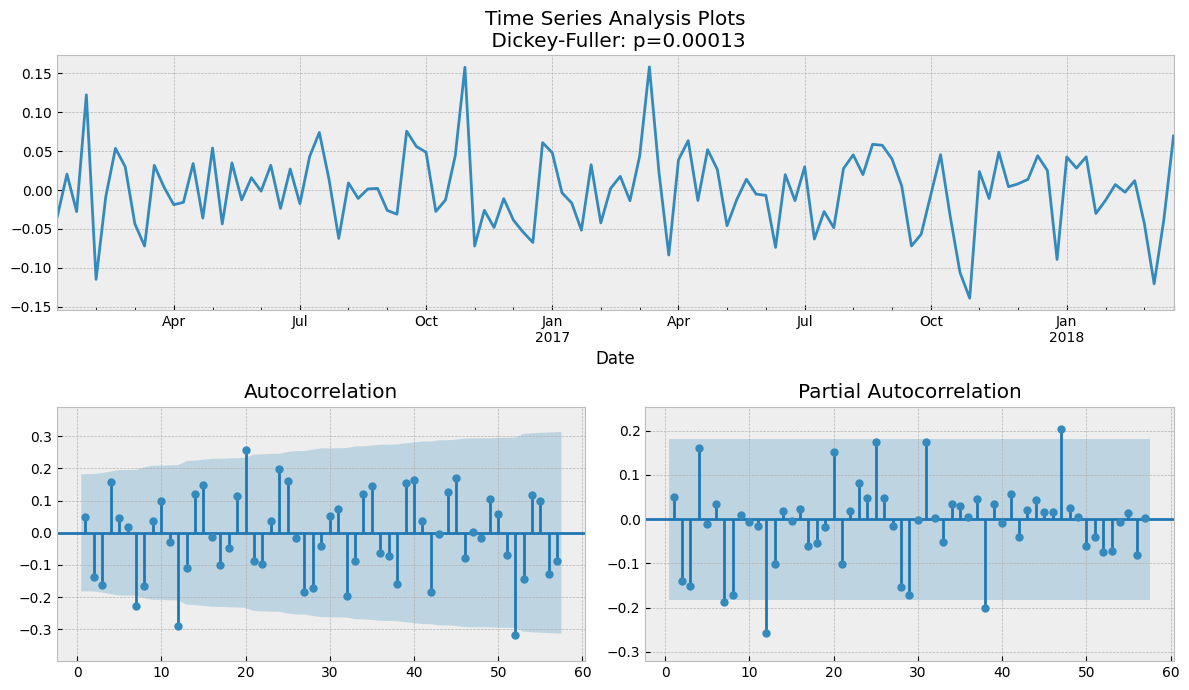

In [13]:
tsplot(df1_log_diff_seas, lags = 57)

Parámetros del modelo SARIMA (P,D,Q,M) :
P : 0
D : 1
Q : 0
M : 52

In [14]:
model = sm.tsa.arima.ARIMA(y_train ,order = (0,1,0),seasonal_order = (0,1,0,52)) #df1['Log_AveragePrice']
model_fit = model.fit()
# model_results = SARIMAXResults(model_fit, specification = {})
# model.resid
print(model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                     AveragePrice   No. Observations:                  135
Model:             ARIMA(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -278.917
Date:                          Mon, 05 Jun 2023   AIC                            559.835
Time:                                  13:17:26   BIC                            562.241
Sample:                              01-04-2015   HQIC                           560.801
                                   - 07-30-2017                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        52.7182      6.137      8.590      0.000      40.690      64.747
Ljung-Box (L1) (Q):                   0.32   Jarque

## Asignación 4

Realice un diagnostico de su modelo para verificar que es correcto.

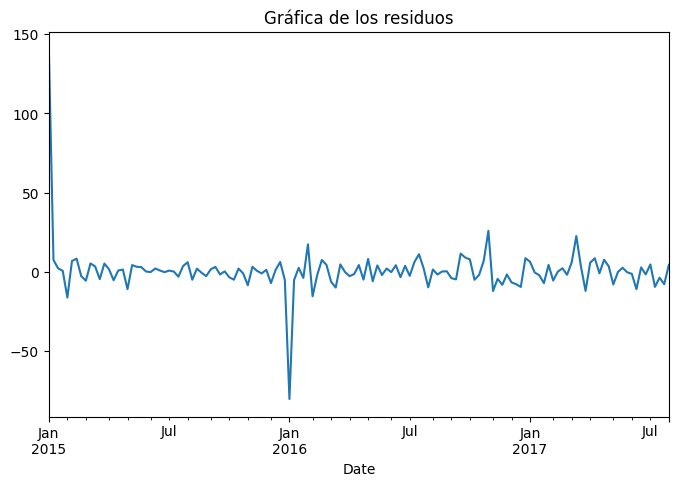

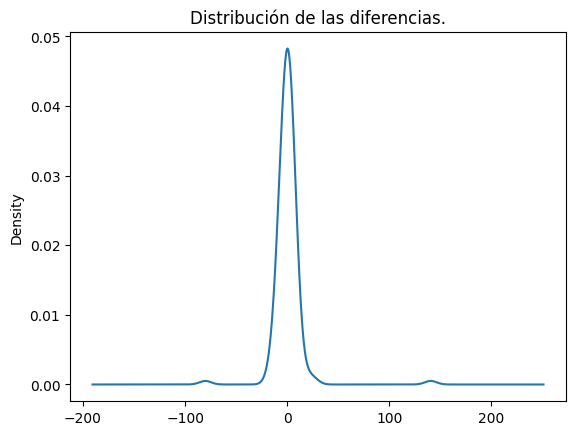

count    135.000000
mean       0.618134
std       15.349939
min      -80.211852
25%       -3.900000
50%        0.210000
75%        3.925000
max      140.540000
dtype: float64

In [21]:
resid = model_fit.resid
#Graficar residuos
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax = model_fit.resid.plot(ax=ax)
plt.title("Gráfica de los residuos")
#plt.ylim([2.5, -2.5])
plt.show()

fig = plt.figure()
resid.plot(kind='kde')
plt.title("Distribución de las diferencias.")
#plt.xlim([-2, 2])
plt.show()

resid.describe()

#https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/


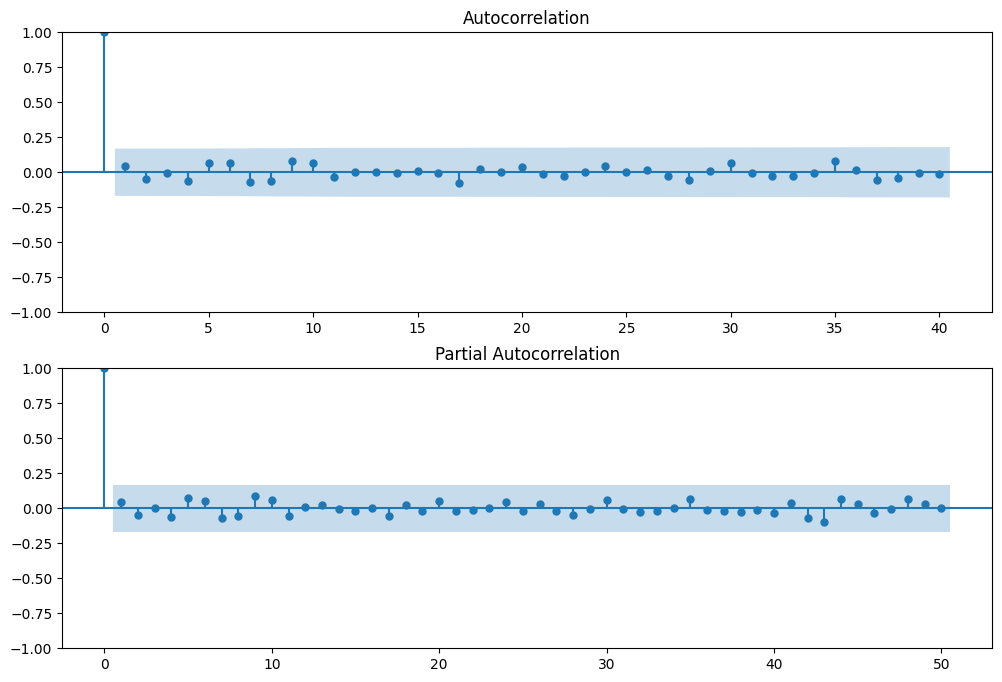

In [16]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=50, ax=ax2)

## Asignación 5

Obtenga el forecast para los datos de test, grafique los valores reales y las predicciones en conjunto. Obtenga el error de regresión para los datos de test.

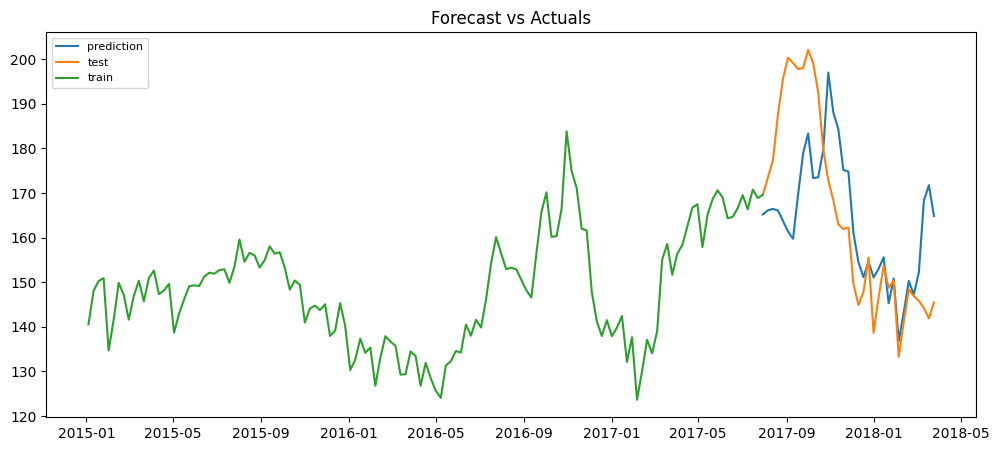

In [17]:
prediction = model_fit.predict(start = '2017-07-30', end = '2018-03-25')
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='test')
plt.plot(y_train, label = 'train')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Métricas de error

In [18]:
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)
rmse = np.sqrt(mean_squared_error(y_test, prediction))

print(f'MAE {mae}')
print(f'MAPE {mape}')
print(f'RMSE {rmse}')

MAE 14.110285714285896
MAPE 0.08174571834200695
RMSE 18.047045820774695


### Dump model

In [19]:
import pickle

with open('modelo_sarima.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b2804db8-c522-4d84-9303-c92a1545f152' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>